## Lesson-06 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
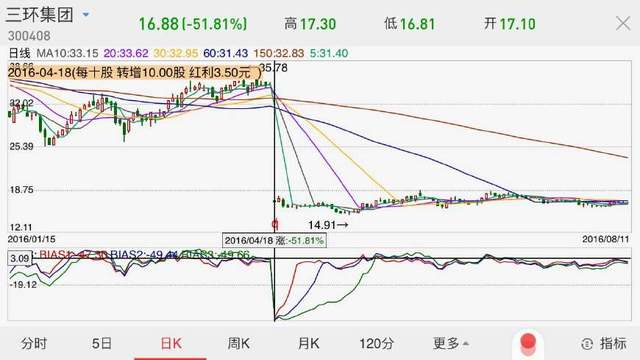

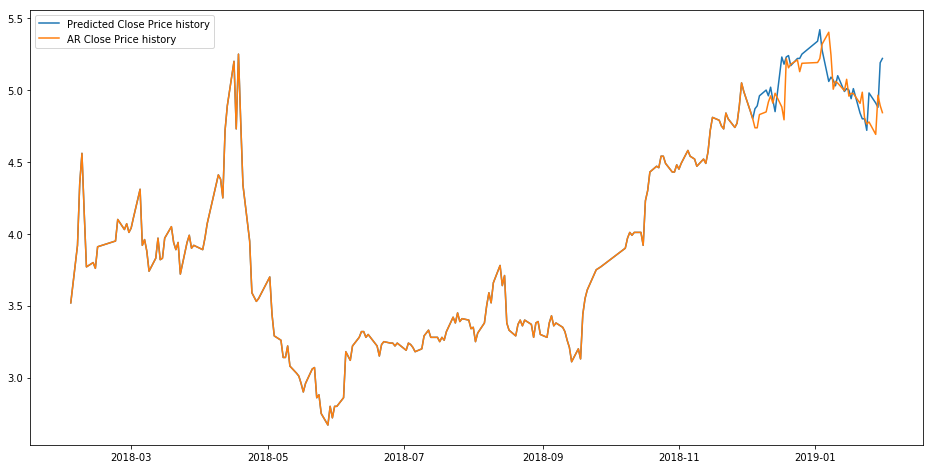

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [157]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/*.txt'))

['/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/Arabic.txt', '/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/Chinese.txt', '/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/Czech.txt', '/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/Dutch.txt', '/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/English.txt', '/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/French.txt', '/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/German.txt', '/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/Greek.txt', '/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/Irish.txt', '/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/Italian.txt', '/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/Japanese.txt', '/Users/jeannewu/Documents/pro

### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [158]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [159]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('/Users/jeannewu/Documents/project/nlp_related_exercise/lesson7/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [160]:
n_categories

18

In [161]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [162]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [163]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [119]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

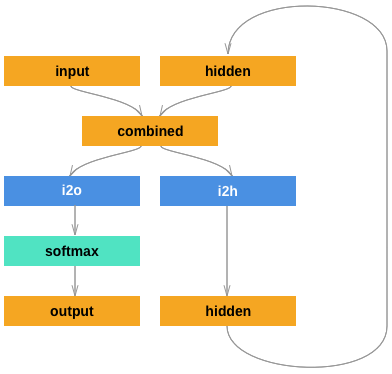

In [164]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        next_hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        # 第二层
        second_combined = torch.cat((input, next_hidden), 1)
        next_hidden = self.i2h(second_combined)
        output = self.i2o(second_combined)
        output = self.softmax(output)
        return output, next_hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

这里定义的是LTSM

In [165]:
rnn = RNN(n_letters, n_hidden, n_categories)

In [209]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size

        self.h0 = torch.randn(2, 3, 20)
        self.c0 = torch.randn(2, 3, 20)
       
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        next_hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, next_hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [211]:
import torch
import torch.nn as nn
from torch.autograd import Variable

#构建网络模型---输入矩阵特征数input_size、输出矩阵特征数hidden_size、层数num_layers
inputs = torch.randn(5,3,10)   #->(seq_len,batch_size,input_size)
rnn = nn.LSTM(10,20,2)    #->   (input_size,hidden_size,num_layers)
h0 = torch.randn(2,3,20)   #->(num_layers* 1,batch_size,hidden_size)
c0 = torch.randn(2,3,20)  # ->(num_layers*1,batch_size,hidden_size) 
num_directions=1

output,(hn,cn) = rnn(inputs,(h0,c0))

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [166]:
input = letter_to_tensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [167]:
output

tensor([[-2.9181, -2.8798, -2.7369, -2.9930, -3.0020, -2.9472, -2.7960, -2.8544,
         -2.8495, -2.8549, -2.9827, -2.8990, -2.9674, -2.9392, -2.9197, -2.7947,
         -2.9484, -2.7957]], grad_fn=<LogSoftmaxBackward>)

In [168]:
next_hidden

tensor([[ 0.1005, -0.0648,  0.0058,  0.0508,  0.0445,  0.1074, -0.0048, -0.0182,
         -0.0277, -0.0716,  0.0041,  0.0534, -0.0477, -0.1129,  0.0025,  0.0595,
         -0.1042, -0.0465, -0.0438, -0.0112, -0.0118, -0.0185, -0.0829,  0.0415,
          0.0178, -0.0018,  0.0798,  0.0583, -0.0858,  0.0555, -0.0176, -0.0586,
         -0.0543, -0.0553, -0.0134, -0.0128, -0.0418, -0.0103, -0.0641, -0.0418,
         -0.0514, -0.0183,  0.0275, -0.0230, -0.1470, -0.0484, -0.0632,  0.0731,
         -0.0846, -0.0037,  0.1336, -0.0403, -0.0062, -0.0844, -0.0143,  0.1359,
         -0.0986,  0.0407,  0.0506,  0.1151,  0.0150, -0.0214, -0.0693, -0.1244,
         -0.0437,  0.0546,  0.0073, -0.0260,  0.0372,  0.0265, -0.0039, -0.1141,
          0.0649, -0.0087, -0.0551,  0.0013,  0.0445,  0.0402,  0.0012, -0.0171,
          0.0482, -0.0169,  0.0621,  0.0042, -0.0601,  0.0118,  0.1074,  0.0651,
          0.0833, -0.0296, -0.0514, -0.0138,  0.0107,  0.0620, -0.0714, -0.0088,
         -0.0528, -0.0077,  

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [169]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9181, -2.8798, -2.7369, -2.9930, -3.0020, -2.9472, -2.7960, -2.8544,
         -2.8495, -2.8549, -2.9827, -2.8990, -2.9674, -2.9392, -2.9197, -2.7947,
         -2.9484, -2.7957]], grad_fn=<LogSoftmaxBackward>)


In [126]:
# for step in range(2):
#     print(step)
#     output, next_hidden = rnn(input[0], hidden)

这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [170]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [171]:
print(category_from_output(output))

('Czech', 2)


### 1.8 随机生成训练数据

In [172]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Than
category = Japanese / line = Ashia
category = Russian / line = Golosenin
category = Polish / line = Zawisza
category = Vietnamese / line = Lac
category = Russian / line = Aniskin
category = Portuguese / line = Araullo
category = Japanese / line = Nakasawa
category = Polish / line = Slazak
category = Chinese / line = Xiao


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [173]:
criterion = nn.CrossEntropyLoss()

In [174]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        # output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [177]:
import time
import math

n_iters = 1000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 50% (0m 1s) 2.8278 Che / Czech ✗ (Chinese)
1000 100% (0m 2s) 2.9157 Rosa / Japanese ✗ (Spanish)


### 1.9 观察Loss的变化

In [178]:
all_losses

[2.897908651828766,
 2.894762477874756,
 2.8845373821258544,
 2.8816107630729677,
 2.8747460627555848,
 2.8669896221160887,
 2.8519363451004027,
 2.8546956324577333,
 2.8524606227874756,
 2.854514391422272]

In [176]:
%matplotlib inline

In [135]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-2.73) Russian
(-2.80) Japanese
(-2.83) Chinese

> Jackson
(-2.65) Russian
(-2.75) English
(-2.76) Irish

> Satoshi
(-2.67) Russian
(-2.70) Japanese
(-2.82) Vietnamese


## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

In [ ]:
def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        next_hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        # 第二层
        second_combined = torch.cat((input, next_hidden), 1)
        next_hidden = self.i2h(second_combined)
        output = self.i2o(second_combined)
        output = self.softmax(output)
        return output, next_hidden> todo

多加了一层，loss小了0.2。

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

> todo

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

> todo

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

> todo